# Analysis of football match statistics and outcomes

## Initial Aims for exploration:
- Import all matches from 2008 - 2016 including data on:
    - Teams involved
    - Match Outcome
    - Match Stats e.g. shots, possession, bookings etc
    - ID of the players in the match day starting 11 plus their ability ratings
    - Other info that can be engineered that I feel is relevant to match outcome

- MVP: Build a model for match prediction for English Premier League games - based on the team stats e.g. avg goals per game, ratings of players in the starting 11

- Stretch 1 - is the style of win changing (2008 - 2011 Tiki Taka in the ascendancy on the continent; 2013- gegenpressing in Germany). Do the match stats show a difference in manner of victory?

The database is in SQL so we'll use SQLite to bring it in and do some initial analysis on a few tables

In [649]:
# imports
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import warnings

warnings.simplefilter('ignore') # this is to ignore warnings that are not useful

### What is in this database?

There are seven SQL tables available. Reading from the Kaggle Data Card:

- **Country**: We will take England only for the MVP (country id 1729) and we'll use this to join up the English Premier League Matches in the Match table

- **League**: The top tier league in all of the countries in Country are here. 
    - Includes Spain, France, Italy and Germany (with England they make up the top 5 European Leagues) and Scotland among others. We are beginning with just England (league id 1729 like the country id)

- **Match**: 26,000 rows with country id and league id. Other columns include:
    - stage, which presumably is the round in the season e.g. in a 20-team home-and-away season of 38 games, stage 1 is the opening round and 38 is the final game day. Easy to audit this - England is 20 teams and there should be exactly 38 stages in every season

    - Home team and away team identifiers; 

    - home goals & away goals
    
    - **home and away players X and Y coordinates.** I think this is their average position. From just eyeballing this, 1 is the goalkeeper and this is very narrowly defined (because goalkeepers don't move much compared to other positions). It's missing for about 7% of records, probably the earlier seasons in some leagues before it was recorded

    - Key match stats, but data appears to be missing for 45% of records (according to the Kaggle data card):
        - Goals
        - Shot on target
        - shot off target
        - foul committed
        - cards
        - crosses
        - corner
        - possession
    
     
    - Bet 365 odds (B365H / B365D / B365A) - ignore for now, we are trying to do our own and could compare to these *later*
        - Lots of other columns which are for betting providers too. We can ignore for now 
            - BWH, BWD, BWA, 
            - IWH, IWD, IWA, 
            - LBH, LBD, LBA... These all have Home, Draw, Away and I think they are all bookmaker stats

- **Player** - Basic info like DOB, Height, Weight

- **Player_Attributes** - more detailed stats like overall_rating, potential, pref. foot, work rates, crossing, finishing etc. This information is provided from the FIFA video games which gives every player a measure of ability

- **Team** - Very basic identifying info like Name & id for link to other tables

- **Team_Attributes** - more detail around build up play statistics and it is recorded once per year. Also comes from FIFA data
    - is it changing over time?

## What Questions can we answer with a predictive model?

### 1. MVP: Can we predict match outcome? Data columns could include
- **Home & away team,** result which we engineer from home goals & away goals, with winning team id
- **OVR Rating of the starting 11**, coming from Player_attributes via player_api_id.
    - Start with avg OVR rating. Then maybe add OVR rating for Strikers, Goalkeeepers
    
- **For more granular data**, bring in players' work rates, GK overall, overall finishing stats.
    - NOTE: there is no data column for player position. There are too many to label manually, so we could implement a rule based on some of the key player stats to identify this. BY far the easiest will be goalkeeper, and we add OVR rating for that.
    - ANy other granular data for the most likely stats to impact goals scored/conceded, because that's the direct influence on the results


### 2. Stretches  - once we have done the MVP

- How does Height/Weight affect style of play? Taller, bulkier players mean a faster long-ball style of play?

-  Physical vs Technical - which ability set is more important in the winning teams?
    - Physical: Acceleration, Sprint Speed, Agility, Reactions, Balance, Jumping, Stamina, Strength
    - Technical: Crossing, Finishing, Heading Acc., Short Passing, Volleys, Dribbling, Curve, FK Acc., Long Passing, Ball Control
    - Mental: Aggression, Interceptions, Positioning, Vision, Penalties (it's psychological)



## Open the database (pandas)

In [650]:
# import the database file
with sqlite3.connect('/Users/thomasdoherty/Desktop/football-project/football-data/database.sqlite') as conn:
    all_countries = pd.read_sql_query("SELECT * from Country", conn)
    all_matches = pd.read_sql_query("SELECT * from Match", conn)
    all_leagues = pd.read_sql_query("SELECT * from League", conn)
    all_teams = pd.read_sql_query("SELECT * from Team", conn)

    # get matches from outside England (league id 1729) for a base rate W/D/L comparison
    european_matches = pd.read_sql_query("SELECT * FROM Match WHERE league_id != 1729", conn)

In [651]:
selected_countries = ['England'] # leave this format in case we want to add more countries later
countries = all_countries[all_countries.name.isin(selected_countries)] # England id is 1729

# merge leagues - it is only going to be premier league, but incase other leagues are added in the future
leagues = countries.merge(all_leagues, on='id', suffixes=('', '_y')) # suffixes = ('', '_y') is to avoid duplicate columns


In [652]:
# checking that English matches have been removed properly
print(european_matches.shape)
print(all_matches.shape)

(22939, 115)
(25979, 115)


In [653]:
# check all columns - more exploration done above and we will remove all the bookies columns soon
all_matches.columns

Index(['id', 'country_id', 'league_id', 'season', 'stage', 'date',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal',
       ...
       'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA'],
      dtype='object', length=115)

In [654]:
matches_prem = all_matches[all_matches.league_id.isin(leagues.id)] 
# Above, we could do league_id == 1729, but this is more flexible when we decide to add more leagues,
# We just add the country name two code cells above and it will work

Below I will **remove the bookmakers odds columns** - they begin with Bet 365 (B365X, where X = H for a bet on the Home team winning; D for Draw, A for Away team, and have many outlets inc. Ladbrookes (LBX), Bet Victor (VCX), William Hill (WHX)) so I will cut off the matches df from the Bet 365 columns onwards.

In [655]:
# 86th column is B365H - remove everything from here onward
matches_prem = matches_prem.iloc[:, :85]

## Initial Data Cleaning & Exploration in Pandas

Initial Look after betting odds columns have been removed:

In [656]:
matches_prem.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession
1728,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1,...,34574.0,37799.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>56</comment><event...
1729,1730,1729,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,1,...,25922.0,27267.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card />,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>65</comment><event...
1730,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,0,...,24635.0,30853.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>45</comment><event...
1731,1732,1729,1729,2008/2009,1,2008-08-16 00:00:00,489045,8654,8528,2,...,127857.0,34466.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>50</comment><event...
1732,1733,1729,1729,2008/2009,1,2008-08-17 00:00:00,489046,10252,8456,4,...,33633.0,107216.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><corners>1</corners></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>51</comment><event...


### Comments for initial cleaning & EDA

- We don't need the country_id and league_id when we know all of these are Premier League games for the MVP. We can remove these columns, keep the id as the index column.

- We can clean the other columns so it is readable e.g. the match stats look like they've been scraped from HTML. We can parse and extract the important stuff like goals.

- Maybe later, we will feature engineer for last five results to show recent form going into this game (date will be important)

- For prediction, the **base rate** is important. Before we introduce any specific team information at all, how often do Home wins, draws or away wins occur? we should look at all leagues for a solid base rate not just England

In [657]:
# make a prem df where we drop the country_id and league_id columns
prem = matches_prem.drop(['country_id', 'league_id'], axis=1)

In [658]:
# rename columns to make them more understandable

# rename stage to round / 38 rounds in a premier league season
prem = prem.rename(columns={'stage': 'Round / 38'})

# rename values in season - split the season before and after the / and take the last two characters of both
prem['season'] = prem['season'].apply(lambda x: x.split('/')[0][2:] + '/' + x.split('/')[1][2:])

prem = prem.rename(columns={'home_team_goal': 'Home GS', 'away_team_goal': 'Away GS', 'home_team_api_id': 'Home ID', 'away_team_api_id': 'Away ID'})

# the same for all_matches
european_matches = european_matches.rename(columns={'home_team_goal': 'Home GS', 'away_team_goal': 'Away GS', 'home_team_api_id': 'Home ID', 'away_team_api_id': 'Away ID'})

# cast the date column to datetime
prem['date'] = pd.to_datetime(prem['date'])

For now we won't use the X and Y coordinates of the players so we will remove those columns

In [659]:
# remove player coordinates more concisely
prem = prem[prem.columns.drop(list(prem.filter(regex='(home|away)_player_(X|Y)[1-9]|(home|away)_player_(X|Y)10|(home|away)_player_(X|Y)11')))]

# cast home_player_1 to home_player_11 to int
# Use a combined regex to match and cast both 'home_player_1' to 'home_player_11' and 'away_player_1' to 'away_player_11' to Int64
prem[prem.filter(regex='(home|away)_player_[1-9]|(home|away)_player_10|11').columns] = \
    prem.filter(regex='(home|away)_player_[1-9]|(home|away)_player_10|11').astype('Int64')

In [660]:
prem.sample(5)

,id,season,Round / 38,date,match_api_id,Home ID,Away ID,Home GS,Away GS,home_player_1,...,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession
2714,2715,10/11,3,2010-08-28,839840,8655,9825,1,2,30622,...,3520,30843,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>48</comment><event...
4551,4552,15/16,24,2016-02-02,1988943,8472,8456,0,1,37233,...,643709,37412,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>36</comment><stats...
4480,4481,15/16,18,2015-12-26,1988882,8455,9817,2,2,170323,...,72436,101419,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>65</comment><stats...
3071,3072,11/12,28,2012-03-10,1025689,8455,10194,1,0,30859,...,30988,33881,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><corners>1</corners></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>76</comment><event...
4530,4531,15/16,22,2016-01-16,1988922,8455,8668,3,3,170323,...,26151,181276,<goal><value><comment>o</comment><stats><owngo...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>57</comment><stats...


Notice the data stops in October 2015 - 9 fixtures into the season when Leicester City won!

In [661]:
prem.columns

Index(['id', 'season', 'Round / 38', 'date', 'match_api_id', 'Home ID',
       'Away ID', 'Home GS', 'Away GS', 'home_player_1', 'home_player_2',
       'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6',
       'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10',
       'home_player_11', 'away_player_1', 'away_player_2', 'away_player_3',
       'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7',
       'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11',
       'goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner',
       'possession'],
      dtype='object')

In [662]:
prem['home_player_1'].sample(5) # spot check for some player IDs later

3253     36374
2779     30455
4459     30974
3868     69650
4701    182917
Name: home_player_1, dtype: Int64

Add a Result column below - positive for home win (+3 means 3 goal victory), 0 for draw, negative for away win

In [663]:
# add the Result Column - 1 if home team wins, 0 if draw, -1 if away team wins
prem.insert(9, 'Result', np.sign(prem['Home GS'] - prem['Away GS']))

# add the Margin column = gives the margin of victory for the home / away team
prem.insert(10, 'Margin', prem['Home GS'] - prem['Away GS'])

# same with the all_matches table
european_matches.insert(9, 'Result', np.sign(european_matches['Home GS'] - european_matches['Away GS']))

european_matches.insert(10, 'Margin', european_matches['Home GS'] - european_matches['Away GS'])

In [664]:
european_matches[european_matches['league_id'] == 1729].head()

,id,country_id,league_id,season,stage,date,match_api_id,Home ID,Away ID,Result,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA


In [665]:
prem.sample(5)

,id,season,Round / 38,date,match_api_id,Home ID,Away ID,Home GS,Away GS,Result,...,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession
1892,1893,08/09,24,2009-01-31,489277,8549,8655,0,0,0,...,30646,34947,<goal />,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>60</comment><event...
4624,4625,15/16,30,2016-03-12,1989006,9850,8456,0,0,0,...,143365,37412,<goal />,<shoton><value><event_incident_typefk>876</eve...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>21</comment><stats...
4158,4159,14/15,23,2015-02-01,1724202,9825,10252,5,0,1,...,148315,184360,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>49</comment><event...
3318,3319,12/13,16,2012-12-08,1229261,9825,8659,2,0,1,...,25550,23293,<goal><value><comment>p</comment><stats><penal...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>59</comment><event...
2454,2455,09/10,6,2009-09-19,658629,8559,10194,1,1,0,...,38755,23288,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>51</comment><event...


### Establishing a Base Rate prediction for Home Win, Draw, Away Win

So far we have made the results and margin columns, which indicate 1 for a home win, 0 for draw and -1 for home loss.

I think we can make a 'base rate' that the model could in future use to predict a result. Let's get some visuals on a very large level how common home vs away wins are.

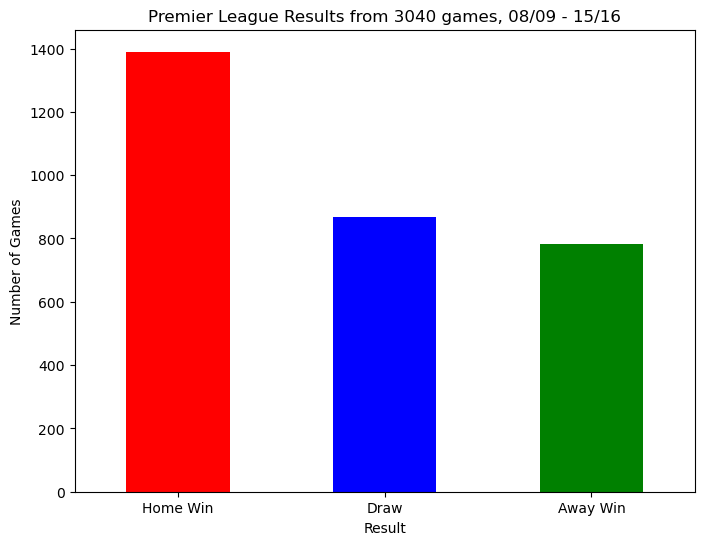

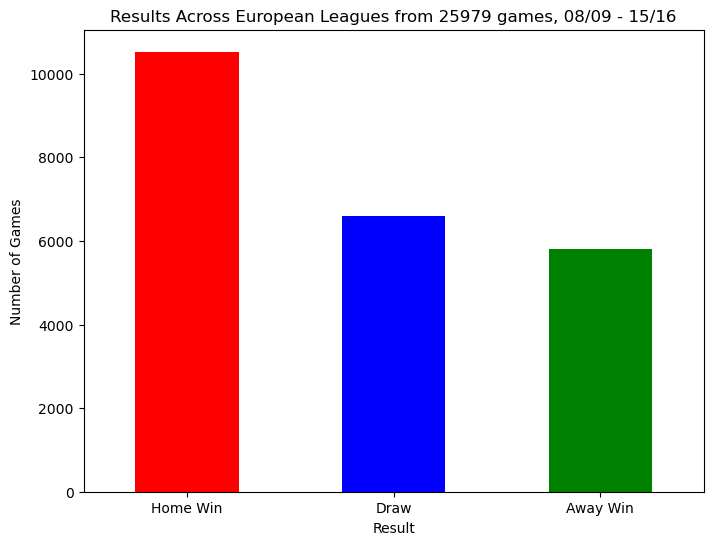

In [666]:
import matplotlib.pyplot as plt

# First figure for the 'prem' dataframe
plt.figure(figsize=(8, 6))
prem['Result'].value_counts().plot(kind='bar', color=['red', 'blue', 'green'])
plt.xticks(ticks=[0, 1, 2], labels=['Home Win', 'Draw', 'Away Win'], rotation=0)
plt.ylabel('Number of Games')
plt.title('Premier League Results from 3040 games, 08/09 - 15/16')
plt.show()

# Second figure for the 'all_matches' dataframe
plt.figure(figsize=(8, 6))
european_matches['Result'].value_counts().plot(kind='bar', color=['red', 'blue', 'green'])
plt.xticks(ticks=[0, 1, 2], labels=['Home Win', 'Draw', 'Away Win'], rotation=0)
# label y axis with total number of games - 25979
plt.ylabel('Number of Games')

# title - Results Across European Leagues from 25979 games, 08/09 - 15/16
plt.title('Results Across European Leagues from 25979 games, 08/09 - 15/16')
plt.show()


In [667]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Count the number of occurrences of each result for 'prem'
prem_result_counts = prem['Result'].value_counts()
prem_labels = ['Home Win', 'Draw', 'Away Win']
prem_values = [prem_result_counts[1], prem_result_counts[0], prem_result_counts[-1]]

# Count the number of occurrences of each result for 'all_matches'
european_matches_result_counts = european_matches['Result'].value_counts()
european_matches_labels = ['Home Win', 'Draw', 'Away Win']
european_matches_values = [european_matches_result_counts[1], european_matches_result_counts[0], european_matches_result_counts[-1]]

# Create a subplot figure with two pie charts
fig = make_subplots(
    rows=1, cols=2, 
    specs=[[{'type': 'domain'}, {'type': 'domain'}]],
    subplot_titles=[
    'Premier League Results, 3040 games, 08/09 - 15/16',
    'Europe (non-PL) Results, 22939 games, 08/09 - 15/16'
])

# Add the first pie chart (for 'prem')
fig.add_trace(
    go.Pie(
        labels=prem_labels,
        values=prem_values,
        hole=0.33,
        textinfo='label+percent',
        textposition='outside',
        showlegend=False
    ),
    row=1, col=1
)

# Add the second pie chart (for 'all_matches')
fig.add_trace(
    go.Pie(
        labels=european_matches_labels,
        values=european_matches_values,
        hole=0.33,
        textinfo='label+percent',
        textposition='outside',
        showlegend=False
    ),
    row=1, col=2
)

# Update the layout of the figure
fig.update_layout(title_text='Comparison of Match Results in England and rest of Europe', title_x=0.5)

# Show the figure
fig.show()


So we can see that Home Win is the most common result by far, almost twice as common as a draw and also far more likely than an Away Win.

These results in England and Europe are remarkably similar across tens of thousands of games in ten years. 

These are strong base rates. I will add these ad columns in the Prem dataframe for the model to see.

In [668]:
# add three columns - P(Home), P(Draw), P(Away) - the probability of each result
prem.insert(11, 'p(Home)', 0.457)
prem.insert(12, 'p(Draw)', 0.258)
prem.insert(13, 'p(Away)', 0.285)

Now we can compare the Margins - how are these distributed? What are specifically the most common results?

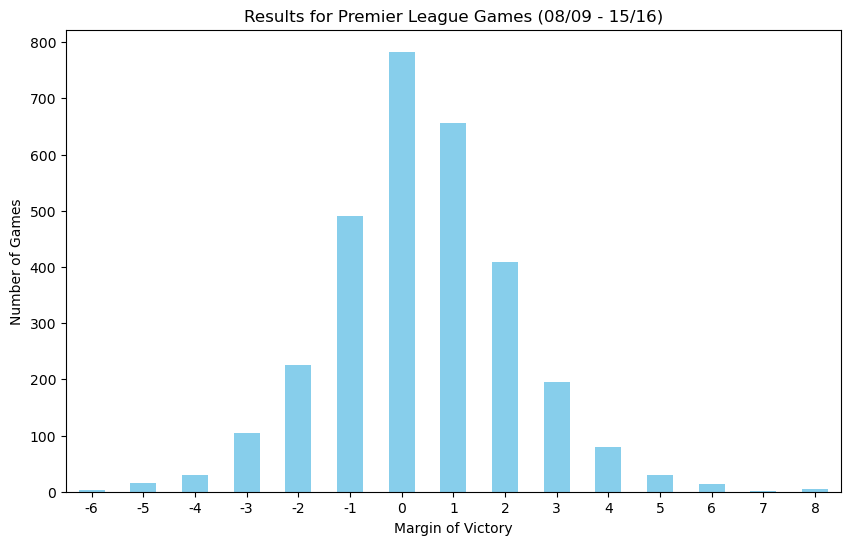

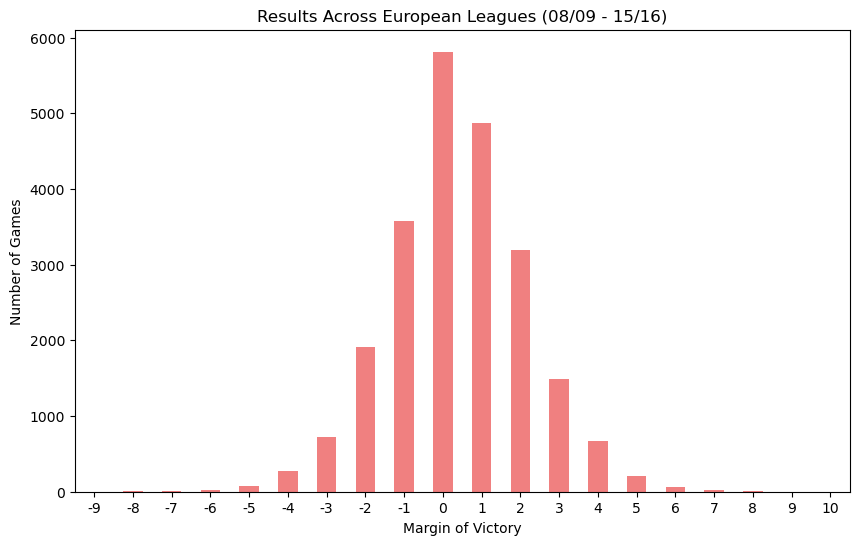

In [669]:
# First figure for the 'prem' dataframe
plt.figure(figsize=(10, 6))
prem['Margin'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.xlabel('Margin of Victory')
plt.ylabel('Number of Games')
plt.title('Results for Premier League Games (08/09 - 15/16)')
plt.xticks(rotation=0)
plt.show()

# Second figure for the 'all_matches' dataframe
plt.figure(figsize=(10, 6))
european_matches['Margin'].value_counts().sort_index().plot(kind='bar', color='lightcoral')
plt.xlabel('Margin of Victory')
plt.ylabel('Number of Games')
plt.title('Results Across European Leagues (08/09 - 15/16)')
plt.xticks(rotation=0)
plt.show()


Again, the results are remarkably similar! Bear in mind that 0 here represents *all draws*, not a 0-0 draw which is how all games begin, so the tendency of a home win by 1 goal is still quite close in frequency.

We will want to tease out 0-0 draws from 1-1 draws if we want to predict the Margin later on, but that is a Stretch goal.

For now, the previous few cells show that a Home Win is nearly twice as frequent as any other result with remarkable consistency across different European football leagues.

**Base Rates**
- Home Win: ~46%
- Away Win: ~28.5%
- Draw: ~ 25.5%

### Frequency of individual results (e.g. 1-0, 2-2, 0-2)

In [670]:
# count every unique combination of home goals vs away goals
prem_goals = prem.groupby(['Home GS', 'Away GS']).size().reset_index(name='Count')
european_matches_goals = european_matches.groupby(['Home GS', 'Away GS']).size().reset_index(name='Count')
prem_goals.head(10)

,Home GS,Away GS,Count
0,0,0,251
1,0,1,213
2,0,2,120
3,0,3,72
4,0,4,23
5,0,5,11
6,0,6,3
7,1,0,308
8,1,1,317
9,1,2,205


In [671]:
# create "Final Score" column to show the result of the match
prem_goals['Final Score'] = prem_goals['Home GS'].astype(str) + ' - ' + prem_goals['Away GS'].astype(str)
european_matches_goals['Final Score'] = european_matches_goals['Home GS'].astype(str) + ' - ' + european_matches_goals['Away GS'].astype(str)


In [672]:
prem_goals[['Home GS', 'Away GS', 'Final Score', 'Count']].sample(5)

,Home GS,Away GS,Final Score,Count
14,2,0,2 - 0,246
24,3,4,3 - 4,6
33,5,0,5 - 0,22
34,5,1,5 - 1,17
39,6,1,6 - 1,7


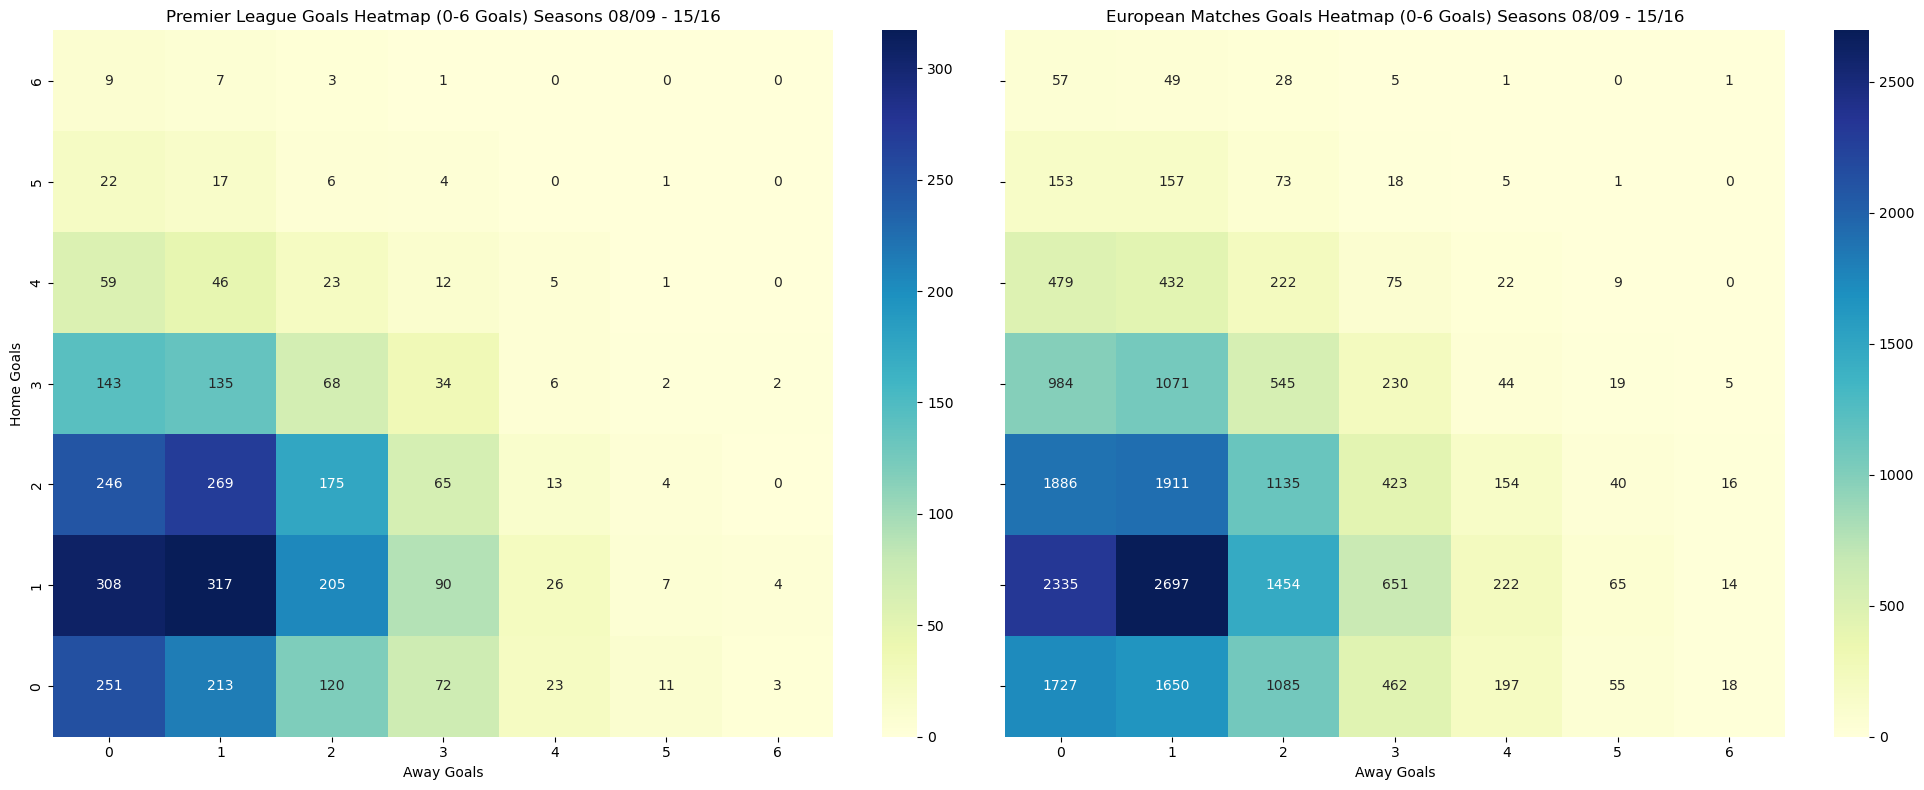

In [673]:
import numpy as np

# Define the range for Home GS and Away GS
goal_range = np.arange(0, 7)  # From 0 to 6 inclusive

# Filter the Premier League matrix to include only 0-6 goals
fixture_matrix = (
    prem_goals.pivot_table(
        index='Home GS',
        columns='Away GS',
        values='Count',
        aggfunc='sum',
        fill_value=0
    )
    .reindex(index=goal_range, columns=goal_range, fill_value=0)
)

# Filter the European Matches matrix to include only 0-6 goals
european_fixture_matrix = (
    european_matches_goals.pivot_table(
        index='Home GS',
        columns='Away GS',
        values='Count',
        aggfunc='sum',
        fill_value=0
    )
    .reindex(index=goal_range, columns=goal_range, fill_value=0)
)

# Reverse the order of rows and columns for both matrices to align (0, 0) in the bottom-left corner
fixture_matrix = fixture_matrix.iloc[::-1]
european_fixture_matrix = european_fixture_matrix.iloc[::-1]

# Create side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Heatmap for Premier League
sns.heatmap(
    fixture_matrix,
    annot=True,
    fmt='d',
    cmap='YlGnBu',
    cbar=True,
    ax=axes[0]
)
axes[0].set_title('Premier League Goals Heatmap (0-6 Goals) Seasons 08/09 - 15/16')
axes[0].set_xlabel('Away Goals')
axes[0].set_ylabel('Home Goals')

# Heatmap for European Matches
sns.heatmap(
    european_fixture_matrix,
    annot=True,
    fmt='d',
    cmap='YlGnBu',
    cbar=True,
    ax=axes[1]
)
axes[1].set_title('European Matches Goals Heatmap (0-6 Goals) Seasons 08/09 - 15/16')
axes[1].set_xlabel('Away Goals')
axes[1].set_ylabel('')  # No y-label on the second plot to avoid redundancy

# Adjust layout
plt.tight_layout()
plt.show()


so 1-1 is the most likely individual score followed by 1-0 (very closely in both!) and from eyeballing this, the % of results are also eerily close for both. 1-0 is a couple of percentage points behind 1-1 in both.

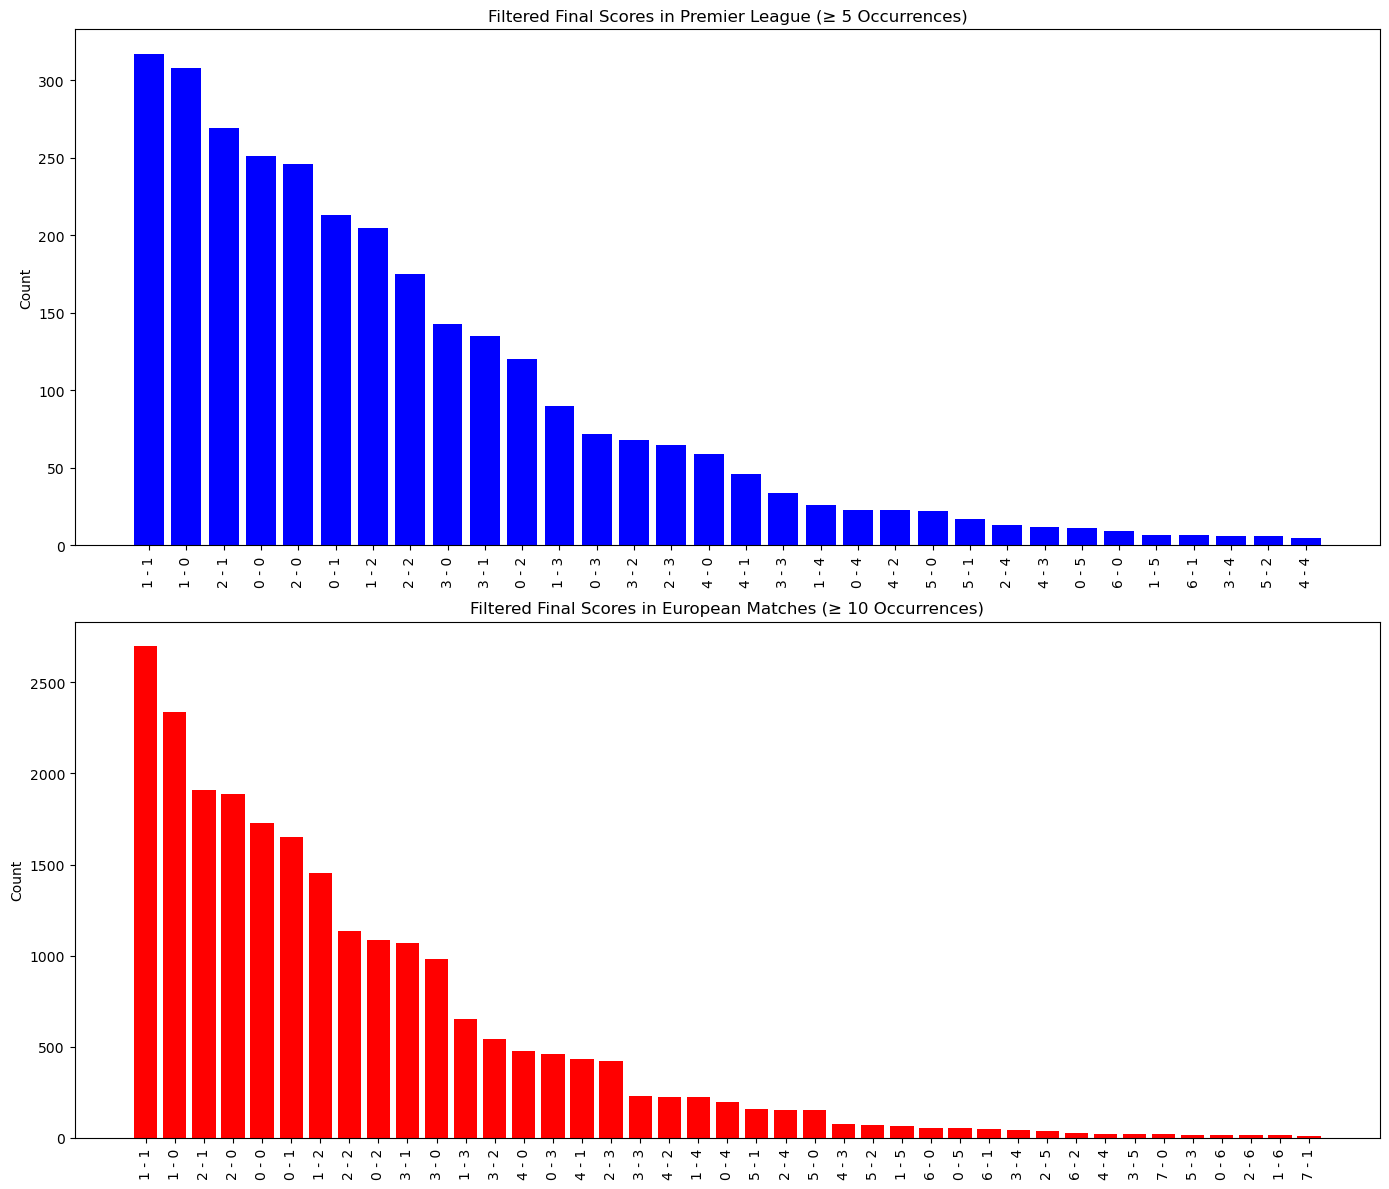

In [674]:
# Filter and sort the Premier League data - trim out the very rare scores
prem_filtered = prem_goals[prem_goals['Count'] >= 5].sort_values(by='Count', ascending=False)

# Filter and sort the European Matches data - trim out the very rare scores
european_filtered = european_matches_goals[european_matches_goals['Count'] >= 10].sort_values(by='Count', ascending=False)

# Create subplots for the filtered bar charts
fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=False)

# Bar chart for Premier League
axes[0].bar(prem_filtered['Final Score'], prem_filtered['Count'], color='blue')
axes[0].set_title('Filtered Final Scores in Premier League (≥ 5 Occurrences)')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=90)

# Bar chart for European Matches
axes[1].bar(european_filtered['Final Score'], european_filtered['Count'], color='red')
axes[1].set_title('Filtered Final Scores in European Matches (≥ 10 Occurrences)')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=90)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


Some differences starting to emerge now - but 1-1, 1-0 and 2-1 still in order the most common results! 0-0 and 2-0 are reversed in Europe and the Prem, but then 0-1, 1-2 and 2-2 are the next most frequent scores in both datasets.

Let's get a % pie chart for the results

In [675]:
import plotly.express as px

# Calculate total matches for each dataset
prem_total = prem_goals['Count'].sum()
european_total = european_matches_goals['Count'].sum()

# Filter and group results for Premier League
prem_goals['Percentage'] = prem_goals['Count'] / prem_total * 100
prem_filtered = prem_goals[prem_goals['Percentage'] >= 2]
prem_other = pd.DataFrame({
    'Final Score': ['Other < 2%'],
    'Count': [prem_goals[prem_goals['Percentage'] < 2]['Count'].sum()]
})
prem_pie_data = pd.concat([prem_filtered[['Final Score', 'Count']], prem_other])

# Filter and group results for European Matches
european_matches_goals['Percentage'] = european_matches_goals['Count'] / european_total * 100
european_filtered = european_matches_goals[european_matches_goals['Percentage'] >= 2]
european_other = pd.DataFrame({
    'Final Score': ['Other < 2%'],
    'Count': [european_matches_goals[european_matches_goals['Percentage'] < 2]['Count'].sum()]
})
european_pie_data = pd.concat([european_filtered[['Final Score', 'Count']], european_other])

# Pie chart for Premier League Final Scores
prem_pie = px.pie(
    prem_pie_data,
    names='Final Score',
    values='Count',
    title='How often does the result occur in 3,000 Premier League matches? (08/09 - 15/16)',
    hole=0.3
)
prem_pie.update_traces(textinfo='label+percent', textposition='outside')
prem_pie.show()

# Pie chart for European Matches Final Scores
european_pie = px.pie(
    european_pie_data,
    names='Final Score',
    values='Count',
    title='How often does the result occur in 22,000 European league matches? (08/09 - 15/16)',
    hole=0.3
)
european_pie.update_traces(textinfo='label+percent', textposition='outside')
european_pie.show()

#### Observations
- The frequency of results across these leagues is staggering! Many individual results are only a single percentage point off each other at most
- Many results are in the same order with less than a quarter of a percentage point off in frequency is very interesting. These give a good base rate of longer term trends we can see.
    - Perhaps later we'll check out if these base rates are changing over time (is home field advantage decreasing over time, for instance?)
- 1-1 is the most common result and in the larger European sample, it is even more so than the PL. 1-0 is next, followed by 2-1 about 1.5 percent down which is close by with 2-0. 
- 0-0 draws are the fourth (PL) or fifth (Europe) most common result and a little bit more frequent in the Premier League.


### Let's explore the HTML of the match stats columns

In [676]:
prem['goal'].iloc[0]

'<goal><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>406</event_incident_typefk><elapsed>22</elapsed><player2>38807</player2><subtype>header</subtype><player1>37799</player1><sortorder>5</sortorder><team>10261</team><id>378998</id><n>295</n><type>goal</type><goal_type>n</goal_type></value><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>393</event_incident_typefk><elapsed>24</elapsed><player2>24154</player2><subtype>shot</subtype><player1>24148</player1><sortorder>4</sortorder><team>10260</team><id>379019</id><n>298</n><type>goal</type><goal_type>n</goal_type></value></goal>'

In [677]:
# check the record with id column 4766 in the goal column - a 0-0 draw
prem[prem['id'] == 4766]['goal']

4765    <goal />
Name: goal, dtype: object

In [678]:
# check where it's a 1-0 win just one entry - the last entry in the data
prem['goal'].iloc[-1]

'<goal><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>649</event_incident_typefk><coordinates><value>21</value><value>2</value></coordinates><elapsed>54</elapsed><subtype>tap_in</subtype><player1>239807</player1><sortorder>4</sortorder><team>8659</team><id>4910256</id><n>559</n><type>goal</type><goal_type>n</goal_type></value></goal>'

It's very hard to read without seeing the nesting. We can use BeautifulSoup to parse this and see what is actually in here, is it anything more detailed than what we see in the goals scored column already?

In [679]:
from bs4 import BeautifulSoup

# prettify the HTML content from a dataframe
def prettify_column(col):
    soup = BeautifulSoup(col, 'html.parser')
    return soup.prettify()

# Applying the function to the goal column
prem['goal_parsed'] = prem['goal'].apply(prettify_column)

# Now, you can print an example entry to see the formatted HTML
print(prem['goal_parsed'].iloc[0])


<goal>
 <value>
  <comment>
   n
  </comment>
  <stats>
   <goals>
    1
   </goals>
   <shoton>
    1
   </shoton>
  </stats>
  <event_incident_typefk>
   406
  </event_incident_typefk>
  <elapsed>
   22
  </elapsed>
  <player2>
   38807
  </player2>
  <subtype>
   header
  </subtype>
  <player1>
   37799
  </player1>
  <sortorder>
   5
  </sortorder>
  <team>
   10261
  </team>
  <id>
   378998
  </id>
  <n>
   295
  </n>
  <type>
   goal
  </type>
  <goal_type>
   n
  </goal_type>
 </value>
 <value>
  <comment>
   n
  </comment>
  <stats>
   <goals>
    1
   </goals>
   <shoton>
    1
   </shoton>
  </stats>
  <event_incident_typefk>
   393
  </event_incident_typefk>
  <elapsed>
   24
  </elapsed>
  <player2>
   24154
  </player2>
  <subtype>
   shot
  </subtype>
  <player1>
   24148
  </player1>
  <sortorder>
   4
  </sortorder>
  <team>
   10260
  </team>
  <id>
   379019
  </id>
  <n>
   298
  </n>
  <type>
   goal
  </type>
  <goal_type>
   n
  </goal_type>
 </value>
</goal>



In [680]:
print(prem['goal_parsed'].iloc[-1])

<goal>
 <value>
  <comment>
   n
  </comment>
  <stats>
   <goals>
    1
   </goals>
   <shoton>
    1
   </shoton>
  </stats>
  <event_incident_typefk>
   649
  </event_incident_typefk>
  <coordinates>
   <value>
    21
   </value>
   <value>
    2
   </value>
  </coordinates>
  <elapsed>
   54
  </elapsed>
  <subtype>
   tap_in
  </subtype>
  <player1>
   239807
  </player1>
  <sortorder>
   4
  </sortorder>
  <team>
   8659
  </team>
  <id>
   4910256
  </id>
  <n>
   559
  </n>
  <type>
   goal
  </type>
  <goal_type>
   n
  </goal_type>
 </value>
</goal>



### goal column contains:
- a < goal /> tag if there are no goals

- a value tag for every goal
    - within this value tag, there is a comment tag which has mostly 'n' but also other letters. I don't know the meaning of it yet
    - elapsed, which may be the minute of the game it was scored,
    - **goal subtype** including header, tap-in, good data here!
    - **coordinates** which must be X and Y, e.g. the tap-in has coordinates value 21, 2 (2 yards out from the goal?)
    - team id
    - id which I assume is a goal_id?

I want to extract:
- goal subtype and see what types they have recorded
- comment, to see if it can be entirely ignored if it's just 'n'
- later on, we will get elapsed, assuming this is time the goal was scored

In [681]:
# Function to extract <comment> and <subtype> values, with a check for <value> tags
def extract_comment_and_subtype(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    
    # Check if there is a <goal> tag and if it contains <value> tags
    goal_tag = soup.find('goal')
    if not goal_tag or not goal_tag.find_all('value'):
        return [], []  # Return empty lists if <goal> or <value> is not found
    
    # Extract all <comment> and <subtype> values within each <value> tag
    comments = [value_tag.find('comment').get_text() for value_tag in goal_tag.find_all('value') if value_tag.find('comment')]
    subtypes = [value_tag.find('subtype').get_text() for value_tag in goal_tag.find_all('value') if value_tag.find('subtype')]
    
    return comments, subtypes

# Apply the function to extract <comment> and <subtype> values from the 'goal' column
prem['goal_comments'], prem['goal_subtypes'] = zip(*prem['goal'].apply(extract_comment_and_subtype))

# Flatten the lists and get unique values
unique_comments = set([comment for sublist in prem['goal_comments'] for comment in sublist])
unique_subtypes = set([subtype for sublist in prem['goal_subtypes'] for subtype in sublist])

# Print the unique comments and subtypes
print("Unique Comments:", unique_comments)
print("Unique Subtypes:", unique_subtypes)


Unique Comments: {'o', 'npm', 'rp', 'n', 'psm', 'dg', 'p'}
Unique Subtypes: {'lob', 'saved_back_into_play', 'indirect freekick', 'missed', 'bicycle_kick', 'shot', 'deflected', 'crossbar', 'volley', 'distance', 'backheel', 'header', 'tap_in', 'direct_freekick', 'loose_ball', 'saved', 'post'}


We can see a lot of different subtypes including 'saved' or 'missed' which doesn't make sense. Let's see which fields have those

In [682]:
# check goal_subtypes for entries containing 'missed' and 'saved'
missed = prem[prem['goal_subtypes'].apply(lambda x: 'missed' in x or 'saved' in x)]

missed

,id,season,Round / 38,date,match_api_id,Home ID,Away ID,Home GS,Away GS,Result,...,shoton,shotoff,foulcommit,card,cross,corner,possession,goal_parsed,goal_comments,goal_subtypes
1769,1770,08/09,13,2008-11-15,489163,9825,10252,0,2,-1,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>56</comment><event...,<goal>\n <value>\n <comment>\n npm\n </com...,"[npm, o, n]","[saved, shot]"
1886,1887,08/09,23,2009-01-28,489271,8655,8559,2,2,0,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>41</comment><event...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, n, npm, n]","[shot, shot, shot, saved, shot]"
1951,1952,08/09,3,2008-08-30,489065,8654,8655,4,1,1,...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>68</comment><event...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, o, n, dg, npm, n, n]","[header, shot, shot, saved, shot, shot]"
1953,1954,08/09,3,2008-08-30,489067,8668,8462,0,3,-1,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>55</comment><event...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, npm, n]","[shot, shot, saved, distance]"
1960,1961,08/09,30,2009-03-21,489335,10261,9825,1,3,-1,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>45</comment><event...,<goal>\n <value>\n <comment>\n npm\n </com...,"[npm, n, n, n, n]","[saved, header, loose_ball, shot, shot]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4480,4481,15/16,18,2015-12-26,1988882,8455,9817,2,2,0,...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>65</comment><stats...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, p, o, n, npm]","[volley, shot, missed]"
4482,4483,15/16,18,2015-12-26,1988884,8456,8472,4,1,1,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>72</comment><stats...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, n, n, n, npm]","[header, distance, header, shot, shot, missed]"
4616,4617,15/16,3,2015-08-23,1988738,8659,8455,2,3,-1,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value>

I was manually trying to compare the sum of Home GS + Away GS with the number of goal subtypes and there are some inconsistencies where saved and missed are involved. We can:

- spot check some records with those and see if goal has a value of 1 or 0
- run a pandas query for these where the sum of goals should add up to the length of the goal_subtypes list

In [683]:
print(missed['goal_parsed'].iloc[-1])

<goal>
 <value>
  <comment>
   n
  </comment>
  <stats>
   <goals>
    1
   </goals>
   <shoton>
    1
   </shoton>
  </stats>
  <event_incident_typefk>
   393
  </event_incident_typefk>
  <coordinates>
   <value>
    23
   </value>
   <value>
    6
   </value>
  </coordinates>
  <elapsed>
   5
  </elapsed>
  <player2>
   103419
  </player2>
  <subtype>
   shot
  </subtype>
  <player1>
   286119
  </player1>
  <sortorder>
   6
  </sortorder>
  <team>
   8197
  </team>
  <id>
   5581005
  </id>
  <n>
   301
  </n>
  <type>
   goal
  </type>
  <goal_type>
   n
  </goal_type>
 </value>
 <value>
  <comment>
   n
  </comment>
  <stats>
   <goals>
    1
   </goals>
   <shoton>
    1
   </shoton>
  </stats>
  <event_incident_typefk>
   80
  </event_incident_typefk>
  <coordinates>
   <value>
    25
   </value>
   <value>
    7
   </value>
  </coordinates>
  <elapsed>
   33
  </elapsed>
  <subtype>
   shot
  </subtype>
  <player1>
   103419
  </player1>
  <sortorder>
   2
  </sortorder>
  <tea

## Pause on Pandas: Bring in key information using SQL to aid the analysis

SQL is going to be a lot easier to bring in information like how many goals on average did a given team score this season, team OVR rating for the season, player OVR ratings etc...

Before going for types of goals, possession etc etc I should be looking at high level team information, which is definitely going to impact the predictive power of the model.

The SQL query to be built is:
- Overall Rating From Player_Attributes, join their name
    - we need code to match the player's OVR ability to the year the match takes place e.g. 2015 match takes the player's 2015 OVR
- Joined by their player_api_id to Match table, which has player ID

In [684]:
# import the database file
with sqlite3.connect('/Users/thomasdoherty/Desktop/football-project/football-data/database.sqlite') as conn:
    # countries = pd.read_sql_query("SELECT England FROM Country", conn) # we don't need it for now, other than country id 1729

    matches = pd.read_sql_query("SELECT * FROM Match WHERE country_id IS 1729", conn)

    # leagues = pd.read_sql_query("SELECT * FROM League", conn) - we don't need this right now

    team = pd.read_sql_query("SELECT * FROM Team", conn)

    team_attr = pd.read_sql_query("""
                                  SELECT Team.team_api_id, team_long_name, date, buildUpPlaySpeed, buildUpPlayPassing, chanceCreationPassing, chanceCreationCrossing, chanceCreationShooting, defencePressure, defenceAggression
                                  FROM Team_Attributes
                                  INNER JOIN Team ON Team.team_api_id = Team_Attributes.team_api_id
                                  """, conn)

    player_attr = pd.read_sql_query("""
                                    SELECT Player.player_api_id, player_name, date, overall_rating 
                                    FROM Player_Attributes 
                                    INNER JOIN Player ON Player.player_api_id = Player_Attributes.player_api_id
                                    """, conn)

    player = pd.read_sql_query("SELECT * FROM Player", conn)

### Preparing the player_attribute table

The goal is to have the player id, their overall rating and the year in which it was assigned. This information will let the player easily be joined in to the matches table with their overall rating which is close to the time of the match in question.
    - We can then later create an average OVR rating of the team in the starting 11.

There are many instances of the same player having a new rating multiple times a year, so we will take an average of the overall rating that was given in each rating across each year.

In [685]:
player_attr[player_attr['player_api_id'] == 23021].head() # before preparation

,player_api_id,player_name,date,overall_rating
21897,23021,Boaz Myhill,2016-02-11 00:00:00,72.0
21898,23021,Boaz Myhill,2015-09-21 00:00:00,72.0
21899,23021,Boaz Myhill,2014-05-16 00:00:00,72.0
21900,23021,Boaz Myhill,2014-03-14 00:00:00,72.0
21901,23021,Boaz Myhill,2013-09-20 00:00:00,72.0


In [686]:
# cast date to datetime
player_attr['date'] = pd.to_datetime(player_attr['date'])

# extract just the year from the date
player_attr['date'] = player_attr['date'].dt.year

In [687]:
# now average the overall_rating for each player for each year, group by player_api_id and date
player_attr = player_attr.groupby(['player_api_id', 'player_name', 'date'])['overall_rating'].mean().reset_index()

# round the overall_rating to 1 decimal place
player_attr['overall_rating'] = player_attr['overall_rating'].round(1)

In [688]:
player_attr.dtypes

player_api_id       int64
player_name        object
date                int32
overall_rating    float64
dtype: object

In [689]:
player_attr.sample(5) # after preparation

,player_api_id,player_name,date,overall_rating
19165,34225,Tomasz Kupisz,2012,68.5
67382,355356,Marc-Oliver Kempf,2007,57.0
15679,31643,David Elm,2013,62.0
11057,27352,Jan Rosenthal,2010,73.0
17774,33579,Oscar Wendt,2015,76.0


### Preparing the team_attribute columns

The goal is to have the team statistics for that year that the match took place. We may only bring in the team name but extra columns related to the style of play will be brought in too. 

I dropped buildUpPlayDribbling / chanceCreationDribbling because it only began getting recorded in 2014 - near the end of the data

Other notes:
- It looks like all teams get one annual rating for team_attr, so all we need to process is extract the year

- Spot check West Ham (long ball) vs Arsenal (short possession based) - it appears the **larger values for passing indicate longer passing distance**, e.g. long-ball teams have a larger buildUpPlaySpeed and buildUpPlayPassing

In [690]:
#teams[teams['team_api_id'] == 8654]

In [691]:
team_attr.sample(5) # before processing

,team_api_id,team_long_name,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression
659,8203,KV Mechelen,2010-02-22 00:00:00,65,60,50,40,50,60,70
1161,8302,Sevilla FC,2015-09-10 00:00:00,53,53,53,52,60,42,48
675,8543,Lazio,2010-02-22 00:00:00,60,50,50,40,70,55,50
445,10243,FC Zürich,2010-02-22 00:00:00,45,60,45,70,50,50,55
767,8689,FC Lorient,2013-09-20 00:00:00,60,42,48,53,64,43,47


In [692]:
team_attr.columns

Index(['team_api_id', 'team_long_name', 'date', 'buildUpPlaySpeed',
       'buildUpPlayPassing', 'chanceCreationPassing', 'chanceCreationCrossing',
       'chanceCreationShooting', 'defencePressure', 'defenceAggression'],
      dtype='object')

In [693]:
# spot check a team to see how this changes - West Ham United and Arsenal
team_attr[team_attr['team_long_name'].isin(['West Ham United', 'Arsenal'])]

,team_api_id,team_long_name,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression
70,9825,Arsenal,2010-02-22 00:00:00,66,30,30,45,35,30,40
71,9825,Arsenal,2011-02-22 00:00:00,75,40,40,45,65,50,40
72,9825,Arsenal,2012-02-22 00:00:00,25,32,41,34,30,57,57
73,9825,Arsenal,2013-09-20 00:00:00,30,29,41,55,39,64,54
74,9825,Arsenal,2014-09-19 00:00:00,59,26,28,55,64,51,44
75,9825,Arsenal,2015-09-10 00:00:00,59,30,28,44,46,51,44
1384,8654,West Ham United,2010-02-22 00:00:00,58,30,31,70,50,30,70
1385,8654,West Ham United,2011-02-22 00:00:00,35,35,30,45,45,45,45
1386,8654,West Ham United,2012-02-22 00:00:00,63,64,44,60,55,30,34
1387,8654,West Ham United,2013-09-20 00:00:00,72,73,61,74,32,30,37


In [694]:
# cast date to datetime
team_attr['date'] = pd.to_datetime(team_attr['date'])

# extract just the year from the date
team_attr['date'] = team_attr['date'].dt.year

In [695]:
team_attr.sample(5)

,team_api_id,team_long_name,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression
154,10211,SC Beira Mar,2013,39,48,53,53,59,37,52
798,8661,RCD Mallorca,2014,62,57,53,57,53,59,41
222,4170,US Boulogne Cote D'Opale,2011,50,35,35,65,65,35,55
486,9987,KRC Genk,2012,53,55,55,48,56,47,45
1022,8696,Racing Santander,2013,47,44,61,71,50,50,50


### Big SQL Query - team match results in England

I want to create a df which has aggregated the win/loss/draw and avg goals scored for all teams in England (where the matches recorded are all from the Premier League).

We will use CASE logic to match the team id only when it is specifically home or away to count the goals scored and the goals per match
We can make it more granular later e.g. home wins/losses, away wins/losses if we want.

We can also adjust the below code to add other leagues for if we wanted to check which teams are most dominant in their leagues.

In [696]:
sql_query = """
SELECT
    Team.team_api_id,
    Team.team_long_name AS name,
    League.name AS league,
    COUNT(Match.id) AS total_matches,
    SUM(CASE
                WHEN Match.home_team_api_id = Team.team_api_id THEN Match.home_team_goal
                WHEN Match.away_team_api_id = Team.team_api_id THEN Match.away_team_goal
                ELSE 0
        END) AS total_GS,
    SUM(CASE
                WHEN Match.home_team_api_id = Team.team_api_id THEN Match.away_team_goal
                WHEN Match.away_team_api_id = Team.team_api_id THEN Match.home_team_goal
                ELSE 0
        END) AS total_GA,
    SUM(CASE 
                WHEN Match.home_team_api_id = Team.team_api_id AND Match.home_team_goal > Match.away_team_goal THEN 1
                WHEN Match.away_team_api_id = Team.team_api_id AND Match.away_team_goal > Match.home_team_goal THEN 1
                ELSE 0 
        END) AS total_wins,
    SUM(CASE
                WHEN Match.home_team_api_id = Team.team_api_id AND Match.home_team_goal = Match.away_team_goal THEN 1
                WHEN Match.away_team_api_id = Team.team_api_id AND Match.away_team_goal = Match.home_team_goal THEN 1
                ELSE 0
        END) AS total_draws,
    SUM(CASE
                WHEN Match.home_team_api_id = Team.team_api_id AND Match.home_team_goal < Match.away_team_goal THEN 1
                WHEN Match.away_team_api_id = Team.team_api_id AND Match.away_team_goal < Match.home_team_goal THEN 1
                ELSE 0
        END) AS total_losses,
    ROUND(AVG(CASE
                WHEN Match.home_team_api_id = Team.team_api_id THEN Match.home_team_goal
                WHEN Match.away_team_api_id = Team.team_api_id THEN Match.away_team_goal
                ELSE 0
        END), 2) AS avg_GS_per_match,
    ROUND(AVG(CASE
                WHEN Match.home_team_api_id = Team.team_api_id THEN Match.away_team_goal
                WHEN Match.away_team_api_id = Team.team_api_id THEN Match.home_team_goal
                ELSE 0
        END), 2) AS avg_GA_per_match

FROM Team

LEFT JOIN Match ON Team.team_api_id IN (Match.home_team_api_id, Match.away_team_api_id)

JOIN League ON League.id = Match.league_id

WHERE Team.team_api_id IS NOT NULL AND League.id = 1729

GROUP BY Team.team_long_name

ORDER BY total_wins DESC;
"""

In [697]:
# SQL query run

big_stats = pd.read_sql_query(sql_query, conn)

In [698]:
big_stats

,team_api_id,name,league,total_matches,total_GS,total_GA,total_wins,total_draws,total_losses,avg_GS_per_match,avg_GA_per_match
0,10260,Manchester United,England Premier League,304,582,280,192,57,55,1.91,0.92
1,8455,Chelsea,England Premier League,304,583,286,176,70,58,1.92,0.94
2,8456,Manchester City,England Premier League,304,606,307,175,61,68,1.99,1.01
3,9825,Arsenal,England Premier League,304,573,320,170,73,61,1.88,1.05
4,8586,Tottenham Hotspur,England Premier League,304,481,358,151,74,79,1.58,1.18
5,8650,Liverpool,England Premier League,304,531,337,150,76,78,1.75,1.11
6,8668,Everton,England Premier League,304,439,355,121,100,83,1.44,1.17
7,10194,Stoke City,England Premier League,304,322,401,98,86,120,1.06,1.32
8,10252,Aston Villa,England Premier League,304,335,462,86,88,130,1.10,1.52
9,10261,Newcastle United,England Premier League,266,324,422,82,65,119,1.22,1.59


In [699]:
big_stats.dtypes # types look good

team_api_id           int64
name                 object
league               object
total_matches         int64
total_GS              int64
total_GA              int64
total_wins            int64
total_draws           int64
total_losses          int64
avg_GS_per_match    float64
avg_GA_per_match    float64
dtype: object

In [700]:
# close the SQL connection
conn.close()

## Progress Check - SQL and Pandas

We have:

- `player_attr` player overall attribute for every year, which can be summed and averaged in the match data table, with player_api to connect to the team
- `team_attr` team statistics, with team_api_id and the date. If we have issues with nulls, we may want to start with just the 2010 - 2015 or 2016 years as some team attribute data is missing from 2008-2009
- `big_stats` aggregated team results for the 33 teams who have competed in the premier league in this 2008-2016 window
- `prem` which is a modified match table where all of this will be aggregated.

In [701]:
# spot check the team_attr for teams that could be pulled in
team_attr[team_attr['team_long_name'].isin(['Middlesbrough', 'Fulham'])]

,team_api_id,team_long_name,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression
478,9879,Fulham,2010,60,70,70,70,50,40,35
479,9879,Fulham,2011,50,55,45,55,40,45,35
480,9879,Fulham,2012,48,45,38,62,54,38,38
481,9879,Fulham,2013,52,49,49,56,59,39,39
482,9879,Fulham,2014,52,56,58,41,54,29,28
483,9879,Fulham,2015,52,48,39,54,59,29,30
829,8549,Middlesbrough,2010,70,70,70,70,50,30,70
830,8549,Middlesbrough,2011,66,51,64,64,48,54,44
831,8549,Middlesbrough,2012,60,72,40,56,72,38,42
832,8549,Middlesbrough,2013,60,40,40,56,57,38,42


### Sample Pulse Check for the four dfs

In [702]:
prem.sample(7)

,id,season,Round / 38,date,match_api_id,Home ID,Away ID,Home GS,Away GS,Result,...,shoton,shotoff,foulcommit,card,cross,corner,possession,goal_parsed,goal_comments,goal_subtypes
2361,2362,09/10,32,2010-03-27,659132,8559,10260,0,4,-1,...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card />,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>50</comment><event...,<goal>\n <value>\n <comment>\n o\n </comme...,"[o, n, n, n]","[shot, shot, shot]"
4173,4174,14/15,24,2015-02-08,1724217,10261,10194,1,1,0,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>60</comment><event...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n]","[shot, header]"
3490,3491,12/13,31,2013-03-30,1229432,8668,10194,1,0,1,...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><event_incident_typefk>595</ev...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>54</comment><event...,<goal>\n <value>\n <comment>\n n\n </comme...,[n],[shot]
3473,3474,12/13,3,2012-09-01,1228306,10003,8472,2,2,0,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><corners>1</corners></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>60</comment><event...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, n, n, n]","[shot, shot, tap_in, header]"
2992,2993,11/12,20,2012-01-03,1025207,8456,8650,3,0,1,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><corners>1</corners></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>52</comment><event...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, p]","[shot, header]"
4551,4552,15/16,24,2016-02-02,1988943,8472,8456,0,1,-1,...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>36</comment><stats...,<goal>\n <value>\n <comment>\n n\n </comme...,[n],[shot]
1900,1901,08/09,25,2009-02-08,489285,8654,10260,0,1,-1,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>35</comment><event...,<goal>\n <value>\n <comment>\n dg\n </comm...,"[dg, n]","[shot, shot]"


In [703]:
player_attr.sample(7)

,player_api_id,player_name,date,overall_rating
39438,89240,Adam Hlousek,2009,59.5
42217,102879,Salva Sevilla,2007,59.0
44079,112117,Diallo Guidilleye,2011,65.5
36621,69085,Tomasz Foszmanczyk,2007,50.0
36377,68516,Ramon Cardozo,2015,72.0
37595,71903,Linus Hallenius,2012,64.0
72973,693171,Ludovic Blas,2016,59.0


In [704]:
team_attr.sample(7)

,team_api_id,team_long_name,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression
20,8564,Milan,2015,48,52,66,36,69,58,57
616,8066,Inverness Caledonian Thistle,2014,61,59,50,57,55,43,41
595,8226,TSG 1899 Hoffenheim,2015,69,53,66,62,59,63,61
309,8455,Chelsea,2013,46,41,46,61,63,42,43
1355,10238,Vitória Setúbal,2012,56,42,54,52,52,37,37
1070,8690,Reggio Calabria,2014,52,56,57,74,53,38,48
791,9864,Málaga CF,2013,45,36,72,69,50,64,58


In [705]:
big_stats.sample(7)

,team_api_id,name,league,total_matches,total_GS,total_GA,total_wins,total_draws,total_losses,avg_GS_per_match,avg_GA_per_match
33,9798,Reading,England Premier League,38,43,73,6,10,22,1.13,1.92
19,9850,Norwich City,England Premier League,152,160,253,39,41,72,1.05,1.66
8,10252,Aston Villa,England Premier League,304,335,462,86,88,130,1.10,1.52
23,8602,Wolverhampton Wanderers,England Premier League,114,118,204,25,28,61,1.04,1.79
16,8528,Wigan Athletic,England Premier League,190,200,320,50,52,88,1.05,1.68
14,10003,Swansea City,England Premier League,190,233,257,62,52,76,1.23,1.35
5,8650,Liverpool,England Premier League,304,531,337,150,76,78,1.75,1.11


## Combining the dataframes

The goal is:
- In the Prem dataframe, we can replace the home_player_x and away_player_x which are currently just IDs with overall ability values using player_attr
- We can also add in an average OVR for both team's starting 11
    - later on, other team attributes we want to investigate
- We may want to add the team's avg GS and GA, but might this be a problem of collinearity with the classification result?
- We can then have a target column for classification of 1 (home win), 0 (draw) or -1 (away win)

In [706]:
prem.sample(5)

,id,season,Round / 38,date,match_api_id,Home ID,Away ID,Home GS,Away GS,Result,...,shoton,shotoff,foulcommit,card,cross,corner,possession,goal_parsed,goal_comments,goal_subtypes
3576,3577,12/13,4,2012-09-15,1228351,10194,8456,1,1,0,...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>48</comment><event...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n]","[shot, header]"
2760,2761,10/11,34,2011-04-23,840187,8472,8528,4,2,1,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><corners>1</corners></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>45</comment><event...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, n, p, n, n]","[distance, header, shot, shot, shot]"
4523,4524,15/16,21,2016-01-13,1988915,8456,8668,0,0,0,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>55</comment><stats...,<goal>\n</goal>\n,[],[]
3459,3460,12/13,29,2013-04-17,1229408,9879,8455,0,3,-1,...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>50</comment><event...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, n]","[distance, header, header]"
1939,1940,08/09,29,2009-03-14,489324,9825,8655,4,0,1,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><event_incident_typefk>123</even...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>58</comment><event...,<goal>\n <value>\n <comment>\n o\n </comme...,"[o, n, n, p]","[shot, volley]"


In [707]:
prem.columns

Index(['id', 'season', 'Round / 38', 'date', 'match_api_id', 'Home ID',
       'Away ID', 'Home GS', 'Away GS', 'Result', 'Margin', 'p(Home)',
       'p(Draw)', 'p(Away)', 'home_player_1', 'home_player_2', 'home_player_3',
       'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7',
       'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11',
       'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4',
       'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8',
       'away_player_9', 'away_player_10', 'away_player_11', 'goal', 'shoton',
       'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession',
       'goal_parsed', 'goal_comments', 'goal_subtypes'],
      dtype='object')

### Adding Player Ratings and Team statistics to prem df

In [708]:
# Convert the 'date' columns to datetime and extract the year
prem['date'] = pd.to_datetime(prem['date'])
prem['year'] = prem['date'].dt.year

player_attr['date'] = pd.to_datetime(player_attr['date'])
player_attr['year'] = player_attr['date'].dt.year

# Function to merge and find the nearest year if an exact match is not available
def merge_with_nearest_year(prem_df, player_attr_df, player_col, rating_col_prefix):
    # Sort player_attr by player_id and year
    player_attr_df = player_attr_df.sort_values(['player_api_id', 'year'])
    
    # Initialize a list to hold the rating data
    ratings = []

    # Iterate over each row in prem_df
    for _, row in prem_df.iterrows():
        player_id = row[player_col]
        match_year = row['year']

        # Filter player_attr for the current player_id
        player_data = player_attr_df[player_attr_df['player_api_id'] == player_id]

        # Find the closest year if there are any records for the player
        if not player_data.empty:
            closest_year = player_data.iloc[(player_data['year'] - match_year).abs().argsort()[:1]].squeeze()
            ratings.append(closest_year['overall_rating'])
        else:
            ratings.append(None)  # Append None if no data is available

    # Add the ratings to the prem_df
    prem_df[rating_col_prefix] = ratings

# Apply the function for home and away players
for n in range(1, 12):
    merge_with_nearest_year(prem, player_attr, f'home_player_{n}', f'home_player_{n}_rating')
    merge_with_nearest_year(prem, player_attr, f'away_player_{n}', f'away_player_{n}_rating')

# adding the team statistics to the prem df
prem = prem.merge(
    big_stats[['team_api_id', 'total_matches', 'avg_GS_per_match', 'avg_GA_per_match']],
    left_on='Home ID',
    right_on='team_api_id',
    how='left'
).rename(columns={
    'total_matches': 'home_total_matches',
    'avg_GS_per_match': 'home_avg_GS_per_match',
    'avg_GA_per_match': 'home_avg_GA_per_match'
}).drop(columns='team_api_id')

prem = prem.merge(
    big_stats[['team_api_id', 'total_matches', 'avg_GS_per_match', 'avg_GA_per_match']],
    left_on='Away ID',
    right_on='team_api_id',
    how='left'
).rename(columns={
    'total_matches': 'away_total_matches',
    'avg_GS_per_match': 'away_avg_GS_per_match',
    'avg_GA_per_match': 'away_avg_GA_per_match'
}).drop(columns='team_api_id')

In [709]:
prem.sample(10)

,id,season,Round / 38,date,match_api_id,Home ID,Away ID,Home GS,Away GS,Result,...,home_player_10_rating,away_player_10_rating,home_player_11_rating,away_player_11_rating,home_total_matches,home_avg_GS_per_match,home_avg_GA_per_match,away_total_matches,away_avg_GS_per_match,away_avg_GA_per_match
1717,3446,12/13,27,2013-02-23,1229392,9798,8528,0,3,-1,...,72.5,77.0,68.0,71.0,38,1.13,1.92,190,1.05,1.68
41,1770,08/09,13,2008-11-15,489163,9825,10252,0,2,-1,...,73.5,76.5,73.0,74.0,304,1.88,1.05,304,1.10,1.52
303,2032,08/09,37,2009-05-16,489406,8549,10252,1,1,0,...,78.5,78.0,66.0,75.0,38,0.74,1.50,304,1.10,1.52
110,1839,08/09,2,2008-08-23,489052,8650,8549,2,1,1,...,85.0,79.0,87.0,78.5,304,1.75,1.11,38,0.74,1.50
1750,3479,12/13,30,2013-03-16,1229418,10252,10172,3,2,1,...,56.0,75.0,74.0,62.0,304,1.10,1.52,114,1.01,1.75
2720,4449,15/16,15,2015-12-05,1988850,9825,8472,3,1,1,...,52.0,70.0,56.0,68.5,304,1.88,1.05,304,1.10,1.45
301,2030,08/09,37,2009-05-16,489404,8586,8456,2,1,1,...,65.0,80.5,83.5,61.0,304,1.58,1.18,304,1.99,1.01
1439,3168,11/12,36,2012-04-28,1026093,8528,10261,4,0,1,...,71.0,67.0,76.5,65.0,190,1.05,1.68,266,1.22,1.59
1575,3304,12/13,14,2012-11-28,1229244,10003,8659,3,1,1,...,72.0,79.5,64.0,74.0,190,1.23,1.35,266,1.15,1.52
2281,4010,14/15,1,2014-08-18,1723983,8191,8455,1,3,-1,...,41.0,51.0,57.0,74.0,76,0.92,1.78,304,1.92,0.94


It looks quite good - lots and lots of columns that need shaving somehow, but we got these in!

Let's check if any nulls are there.

In [710]:
# check every column for nulls by the columns with the most first
prem.isnull().sum().sort_values(ascending=False).head(20)

away_player_2            8
away_player_10           8
away_player_2_rating     8
away_player_10_rating    8
home_player_10           7
away_player_5_rating     7
away_player_7_rating     7
home_player_2            7
home_player_8_rating     7
away_player_5            7
home_player_8            7
home_player_10_rating    7
away_player_7            7
home_player_2_rating     7
away_player_9            6
away_player_9_rating     6
away_player_11_rating    5
home_player_7_rating     5
away_player_11           5
home_player_7            5
dtype: int64

We can see from the above that there are a handful of empty/null ratings because there's a null in the player_id column itself. e.g. away 10 and away 2 both have 8 nulls in the id and the rating.

There are onyl single digit number of nulls across over 3,000 games. For completeness, we can just fill the nulls ratings with the average of the respective team e.g. if away 10_rating is null, give him the average rating of the team around him.

In [711]:
# fill the home_player_x and away_player_x rating columns, if null, with the mean of the team's overall_rating
for n in range(1, 12):
    # Calculate the mean of the other players' ratings for the home team, each row
    home_rating_cols = [f'home_player_{i}_rating' for i in range(1, 12) if i != n] # if i != n is to exclude the current player in case the null is here
    prem[f'home_player_{n}_rating'] = prem.apply(
        lambda row: row[home_rating_cols].mean() if pd.isnull(row[f'home_player_{n}_rating']) else row[f'home_player_{n}_rating'],
        axis=1
    ) # for every row, run through the home player ratings and take the mean if the rating is null

    # same for away team
    away_rating_cols = [f'away_player_{i}_rating' for i in range(1, 12) if i != n]
    prem[f'away_player_{n}_rating'] = prem.apply(
        lambda row: row[away_rating_cols].mean() if pd.isnull(row[f'away_player_{n}_rating']) else row[f'away_player_{n}_rating'],
        axis=1
    )

In [712]:
# check for nulls again - only the IDs, not the ratings!
prem.isnull().sum().sort_values(ascending=False).head()

away_player_10    8
away_player_2     8
home_player_10    7
home_player_8     7
away_player_5     7
dtype: int64

In [713]:
prem.sample(10)

,id,season,Round / 38,date,match_api_id,Home ID,Away ID,Home GS,Away GS,Result,...,home_player_10_rating,away_player_10_rating,home_player_11_rating,away_player_11_rating,home_total_matches,home_avg_GS_per_match,home_avg_GA_per_match,away_total_matches,away_avg_GS_per_match,away_avg_GA_per_match
2306,4035,14/15,11,2014-11-09,1724088,10003,9825,2,1,1,...,64.0,72.0,56.0,64.0,190,1.23,1.35,304,1.88,1.05
996,2725,10/11,30,2011-03-19,840151,8659,9825,2,2,0,...,75.0,83.0,79.5,85.5,266,1.15,1.52,304,1.88,1.05
449,2178,09/10,15,2009-12-05,658818,9825,10194,2,0,1,...,85.0,78.5,83.0,67.0,304,1.88,1.05,304,1.06,1.32
1026,2755,10/11,33,2011-04-27,840180,9879,8559,3,0,1,...,84.0,82.5,73.0,77.5,228,1.16,1.40,152,1.19,1.66
653,2382,09/10,34,2010-04-14,659152,8586,9825,2,1,1,...,65.0,73.0,83.5,85.0,304,1.58,1.18,304,1.88,1.05
2219,3948,13/14,38,2014-05-11,1475120,8659,10194,1,2,-1,...,72.0,56.0,59.0,46.0,266,1.15,1.52,304,1.06,1.32
1622,3351,12/13,19,2012-12-26,1229298,8668,8528,2,1,1,...,67.0,76.5,70.5,77.0,304,1.44,1.17,190,1.05,1.68
1704,3433,12/13,26,2013-02-09,1229377,9850,9879,0,0,0,...,62.5,84.5,66.0,73.0,152,1.05,1.66,228,1.16,1.40
468,2197,09/10,17,2009-12-16,658837,8650,8528,2,1,1,...,83.5,75.0,61.0,73.0,304,1.75,1.11,190,1.05,1.68
1757,3486,12/13,30,2013-03-16,1229426,10003,9825,0,2,-1,...,67.0,52.0,64.0,56.0,190,1.23,1.35,304,1.88,1.05


## Joins and merges complete - Further cleaning & Feature Engineering of the prem dataframe

### Summary so far and plans ahead:

We have created a master `prem` dataframe which has all the matches from 08/09 to 15/16. Columns of value include
- Match data such as:
    - Team IDs, 
    - date of the fixture,
    - match week of 38. Probably not relevant for predicting the result, but maybe for details match stats later.

- Player data for the home and away players such as:
    - Individual player's overall ratings on both teams, that are recent to the match date

- Team data for the home and away team such as:
    - Team's total number of matches in the league in the reference period. 
    - Teams avg goals scored (GS) and goals against (GA) per game in the time window.
    - These might be a complicated one because that's gathering future information if we are predicting a game early on in the time window.
    
- Details match information like shots, types of goal scored, possession, bookings etc etc but these are heavily nested in columns which we need to dig out later.

Now we can clean a number of unneccessary columns and add one important one:
- Create an average 'team' rating for each match. I think this will be the best way to construct a simple model with some predictive power before complicating things with 22 individual player ratings.

- Remove the individual player IDs, match_api_id

- **For now** remove the Round / 38 aka gameweek, home and away_total matches


### Removing currently (MVP) unnecessary columns

In [714]:
# drop the Round / 38 column, match_api_id, home_total_matches, away_total_matches, year
prem = prem.drop(['Round / 38', 'match_api_id', 'home_total_matches', 'away_total_matches', 'year'], axis=1)

In [715]:
# drop the home/away_player_X columns but NOT the ratings
prem = prem.drop(prem.filter(regex='^(home|away)_player_[1-9]$|^(home|away)_player_10$|^(home|away)_player_11$').columns, axis=1)

In [716]:
# remove the match detail columns - goal, shoton, shotoff, foulcommit, card, cross, corner, possession, goal_parsed, goal_comments, goal_subtypes
prem = prem.drop(['goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession', 'goal_parsed', 'goal_comments', 'goal_subtypes'], axis=1)

In [717]:
prem.columns

Index(['id', 'season', 'date', 'Home ID', 'Away ID', 'Home GS', 'Away GS',
       'Result', 'Margin', 'p(Home)', 'p(Draw)', 'p(Away)',
       'home_player_1_rating', 'away_player_1_rating', 'home_player_2_rating',
       'away_player_2_rating', 'home_player_3_rating', 'away_player_3_rating',
       'home_player_4_rating', 'away_player_4_rating', 'home_player_5_rating',
       'away_player_5_rating', 'home_player_6_rating', 'away_player_6_rating',
       'home_player_7_rating', 'away_player_7_rating', 'home_player_8_rating',
       'away_player_8_rating', 'home_player_9_rating', 'away_player_9_rating',
       'home_player_10_rating', 'away_player_10_rating',
       'home_player_11_rating', 'away_player_11_rating',
       'home_avg_GS_per_match', 'home_avg_GA_per_match',
       'away_avg_GS_per_match', 'away_avg_GA_per_match'],
      dtype='object')

### Creating a home and away team match-day overall rating

In [718]:
# Calculate the average overall rating for the home team players
home_rating_cols = [f'home_player_{n}_rating' for n in range(1, 12)]
prem['home_avg_rating'] = prem[home_rating_cols].mean(axis=1)

# Calculate the average overall rating for the away team players
away_rating_cols = [f'away_player_{n}_rating' for n in range(1, 12)]
prem['away_avg_rating'] = prem[away_rating_cols].mean(axis=1)

In [719]:
prem.columns

Index(['id', 'season', 'date', 'Home ID', 'Away ID', 'Home GS', 'Away GS',
       'Result', 'Margin', 'p(Home)', 'p(Draw)', 'p(Away)',
       'home_player_1_rating', 'away_player_1_rating', 'home_player_2_rating',
       'away_player_2_rating', 'home_player_3_rating', 'away_player_3_rating',
       'home_player_4_rating', 'away_player_4_rating', 'home_player_5_rating',
       'away_player_5_rating', 'home_player_6_rating', 'away_player_6_rating',
       'home_player_7_rating', 'away_player_7_rating', 'home_player_8_rating',
       'away_player_8_rating', 'home_player_9_rating', 'away_player_9_rating',
       'home_player_10_rating', 'away_player_10_rating',
       'home_player_11_rating', 'away_player_11_rating',
       'home_avg_GS_per_match', 'home_avg_GA_per_match',
       'away_avg_GS_per_match', 'away_avg_GA_per_match', 'home_avg_rating',
       'away_avg_rating'],
      dtype='object')

In [720]:
prem.sample(10)

,id,season,date,Home ID,Away ID,Home GS,Away GS,Result,Margin,p(Home),...,home_player_10_rating,away_player_10_rating,home_player_11_rating,away_player_11_rating,home_avg_GS_per_match,home_avg_GA_per_match,away_avg_GS_per_match,away_avg_GA_per_match,home_avg_rating,away_avg_rating
1954,3683,13/14,2013-12-04,10194,8344,0,0,0,0,0.457,...,68.0,72.0,77.0,74.0,1.06,1.32,0.84,1.95,61.045455,61.727273
2226,3955,13/14,2013-09-14,10194,8456,0,0,0,0,0.457,...,76.5,75.0,62.0,67.0,1.06,1.32,1.99,1.01,60.727273,71.954545
2237,3966,13/14,2013-09-21,9850,10252,0,1,-1,-1,0.457,...,82.5,58.0,57.0,56.0,1.05,1.66,1.10,1.52,64.954545,64.272727
161,1890,08/09,2009-01-31,9825,8654,0,0,0,0,0.457,...,79.0,73.0,73.0,82.0,1.88,1.05,1.23,1.44,77.181818,74.363636
1962,3691,13/14,2013-12-08,9879,10252,2,0,1,2,0.457,...,69.0,56.0,84.5,74.0,1.16,1.40,1.10,1.52,76.090909,58.818182
2804,4533,15/16,2016-01-16,8456,9826,4,0,1,4,0.457,...,67.0,46.5,80.0,64.0,1.99,1.01,1.04,1.32,70.136364,58.772727
1600,3329,12/13,2013-01-16,8455,8466,2,2,0,0,0.457,...,51.0,44.0,65.0,64.0,1.92,0.94,1.42,1.18,70.000000,60.772727
1395,3124,11/12,2012-04-07,9850,8668,2,2,0,0,0.457,...,62.5,77.0,61.5,67.0,1.05,1.66,1.44,1.17,59.363636,73.545455
2645,4374,14/15,2014-10-18,10261,8197,1,0,1,1,0.457,...,66.0,49.0,67.0,64.0,1.22,1.59,1.50,1.20,63.681818,63.681818
230,1959,08/09,2009-03-22,8650,10252,5,0,1,5,0.457,...,76.5,78.0,87.0,75.0,1.75,1.11,1.10,1.52,81.090909,77.636364


### drop the individual player ratings to simplify the df for now

In [721]:
# drop the home/away_player_X_rating columns
prem = prem.drop(prem.filter(regex='^(home|away)_player_[1-9]_rating$|^(home|away)_player_10_rating$|^(home|away)_player_11_rating$').columns, axis=1)

Home / Away net goals - this should standardize around 0 for teams that score and concede equally, and negative for 'weak' teams while positive for 'good' teams

In [722]:
# create a new net goals column for both teams: home_avg_GS_per_match - home_avg_GA_per_match and away_avg_GS_per_match - away_avg_GA_per_match
prem['home_net_goals'] = prem['home_avg_GS_per_match'] - prem['home_avg_GA_per_match']
prem['away_net_goals'] = prem['away_avg_GS_per_match'] - prem['away_avg_GA_per_match']

In [723]:
# drop the home_avg_GS_per_match, home_avg_GA_per_match, away_avg_GS_per_match, away_avg_GA_per_match
prem = prem.drop(['home_avg_GS_per_match', 'home_avg_GA_per_match', 'away_avg_GS_per_match', 'away_avg_GA_per_match'], axis=1)

In [724]:
prem.columns

Index(['id', 'season', 'date', 'Home ID', 'Away ID', 'Home GS', 'Away GS',
       'Result', 'Margin', 'p(Home)', 'p(Draw)', 'p(Away)', 'home_avg_rating',
       'away_avg_rating', 'home_net_goals', 'away_net_goals'],
      dtype='object')

In [725]:
# reorganize the dataframe: id, season, date, home team stats, away team stats, result, margin
prem = prem[['id', 'season', 'date', 'Home ID', 'home_avg_rating', 'home_net_goals', 'Away ID', 'away_avg_rating', 'away_net_goals', 'Result', 'Margin', 'p(Home)', 'p(Draw)', 'p(Away)']]

In [726]:
# drop the date, Home ID, Away ID columns
prem = prem.drop(['id', 'date', 'Home ID', 'Away ID'], axis=1)

# round the avg_rating columns to 1 decimal places
prem['home_avg_rating'] = prem['home_avg_rating'].round(1)
prem['away_avg_rating'] = prem['away_avg_rating'].round(1)

In [727]:
def season_to_number(season): # convert the season to a number
    try:
        # Strip any whitespace and split by '/'
        season = season.strip()
        # Extract the first year (e.g., '08' from '08/09')
        year = int(season.split('/')[0])
        # Subtract 7 to start numbering from 1 for '08/09'
        return year - 7
    except (ValueError, AttributeError):
        print(f"Invalid season value: {season}")
        return None  # Handle invalid cases gracefully

In [728]:
print(prem['season'].unique())

['08/09' '09/10' '10/11' '11/12' '12/13' '13/14' '14/15' '15/16']


In [729]:
prem['season'].isnull().sum()

0

In [730]:
prem.sample(10)

,season,home_avg_rating,home_net_goals,away_avg_rating,away_net_goals,Result,Margin,p(Home),p(Draw),p(Away)
1637,12/13,66.8,-0.35,63.0,-0.79,1,3,0.457,0.258,0.285
2492,14/15,69.6,0.98,61.5,0.24,0,0,0.457,0.258,0.285
1609,12/13,68.8,-0.37,72.2,-0.21,0,0,0.457,0.258,0.285
1074,10/11,72.9,0.27,83.6,0.98,1,1,0.457,0.258,0.285
2428,14/15,64.6,0.40,70.9,-0.35,1,1,0.457,0.258,0.285
1617,12/13,68.2,-0.37,63.5,-0.61,1,1,0.457,0.258,0.285
1958,13/14,74.9,-0.24,69.0,0.40,-1,-1,0.457,0.258,0.285
430,09/10,68.6,-0.67,81.1,0.99,-1,-3,0.457,0.258,0.285
2431,14/15,66.4,0.98,77.0,0.98,0,0,0.457,0.258,0.285
2032,13/14,70.9,0.27,60.9,-0.61,1,2,0.457,0.258,0.285


This is looking good! You can already eyeball a few predictions - the gap in net_goals between home and away, the gap in avg_rating for home and away